In [106]:
import pandas as pd
import numpy as np

### Import dataset

In [107]:
df = pd.read_csv('./datasets/house_prices.csv')
df.shape

(15327, 17)

In [108]:
# rename columns
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['title', 'sub_title', 'price', 'address', 'baths', 'land_size', 'beds',
       'house_size', 'location', 'description', 'post_url', 'seller_name',
       'seller_type', 'published_date', 'geo_address', 'lat', 'lon'],
      dtype='object')

In [109]:
df.head(3)

,title,sub_title,price,address,baths,land_size,beds,house_size,location,description,post_url,seller_name,seller_type,published_date,geo_address,lat,lon
0,House with Land for Sale in Matara for sale,"Posted on 06 Nov 2:32 pm, Matara City, Matara","Rs 5,400,000","Gangodagama Roard,Hakmana,Matara.",1,50.0 perches,3,"1,600.0 sqft","Matara City, Matara","Land for sale with house Matara,Hakmana Gangod...",https://ikman.lk/en/ad/house-with-land-for-sal...,Ishara Dilshan,Member,2021-11-06 14:32:00,"Matara City, Matara, Sri Lanka",80.500000,6.166670
1,à¶ à¶½à·à¶­à· à¶à·à¶¸à¶» 3 à¶ à¶à·à· à...,"Posted on 24 Oct 7:27 am, Athurugiriya, Colombo","Rs 16,800,000",Athurugiriya Galwarusapare,3,8.0 perches,3,"1,480.0 sqft","Athurugiriya, Colombo",*House For Sale In Athurugiriya *Galwarusapare...,https://ikman.lk/en/ad/alut-kaamr-3-k-grh-bhaa...,DILRUWAN REAL ESTATE,Premium-Member,2021-10-24 07:27:00,"Athurugiriya, Colombo, Sri Lanka",79.989929,6.877246
2,Kelaniya - House on 20P Land for sale for sale,"Posted on 17 Nov 5:19 pm, Kelaniya, Gampaha","Rs 20,000,000",Kelaniya- Ranaviru Maldeniya Road,2,20.0 perches,3,"2,800.0 sqft","Kelaniya, Gampaha","Kelaniya- Biyagama road, Ranaviru Maladeniya R...",https://ikman.lk/en/ad/kelaniya-house-on-20p-l...,Provident Paradise (Pvt) Ltd,Member,2021-11-17 17:19:00,"Kelaniya, Gampaha, Sri Lanka",79.914926,6.951178


In [110]:
# switch lat and lon columns since they are switched
df = df.rename(columns={'lat': 'lon', 'lon': 'lat'})

 ### Remove irrelevant attributes
The dataset contains platform specific attributes, which does not fit into the general model
- title - title of the post
- sub_title - subtitle of the post
- post_url - url of the post
- seller_name - name of the seller
- seller_type - type of the seller
- description - description of the post

In [111]:
df = df.drop(columns=['title', 'sub_title', 'post_url', 'seller_name', 'seller_type', 'description'], errors='ignore')
df.shape

(15327, 11)

### Remove redundant attributes
Address, location and geo_address contain the same information. Remove address and location since geo_address is more structured

In [112]:
df = df.drop(columns=['address', 'location'], errors='ignore')
df.shape

(15327, 9)

### remove missing values and duplicates

In [113]:
print('missing values:\n', df.isna().sum(), sep='')

# drop rows with missing values
df = df.dropna()


missing values:
price             0
baths             0
land_size         0
beds              0
house_size        0
published_date    0
geo_address       0
lon               0
lat               0
dtype: int64


In [114]:
print('duplicated rows:', df.duplicated().sum())

# drop duplicated rows
df.drop_duplicates(inplace=True)

duplicated rows: 691


In [115]:
df.head()

,price,baths,land_size,beds,house_size,published_date,geo_address,lon,lat
0,"Rs 5,400,000",1,50.0 perches,3,"1,600.0 sqft",2021-11-06 14:32:00,"Matara City, Matara, Sri Lanka",80.500000,6.166670
1,"Rs 16,800,000",3,8.0 perches,3,"1,480.0 sqft",2021-10-24 07:27:00,"Athurugiriya, Colombo, Sri Lanka",79.989929,6.877246
2,"Rs 20,000,000",2,20.0 perches,3,"2,800.0 sqft",2021-11-17 17:19:00,"Kelaniya, Gampaha, Sri Lanka",79.914926,6.951178
3,"Rs 187,000,000",5,22.0 perches,5,"4,000.0 sqft",2021-11-17 17:07:00,"Colombo 6, Colombo, Sri Lanka",80.016670,6.866670
4,"Rs 1,300,000",1,6.3 perches,2,900.0 sqft,2021-11-17 17:06:00,"Dehiwala, Colombo, Sri Lanka",79.880242,6.838232


### Concept hierarchy generation
use geo_address to generate a concept hierarchy for the location attribute
- level 1: country
- level 2: district
- level 3: city

In [116]:
df[['city', 'district', 'country']] = df['geo_address'].str.lower().str.split(',', n=2, expand=True).apply(lambda x: x.str.strip())
df = df.drop(columns=['geo_address'], errors='ignore')

countries = df['country'].unique()
districts = df['district'].unique()
cities = df['city'].unique()

print(f'countries ({len(countries)}): {countries[:5]}')
print(f'districts ({len(districts)}): {districts[:5]}')
print(f'cities ({len(cities)}): {cities[:5]}')

countries (1): ['sri lanka']
districts (24): ['matara' 'colombo' 'gampaha' 'kandy' 'jaffna']
cities (172): ['matara city' 'athurugiriya' 'kelaniya' 'colombo 6' 'dehiwala']


In [117]:
# remove country column since all values are sri lanka
df = df.drop(columns=['country'], errors='ignore')

In [118]:
# pick top 10 districts by frequency as features
district_freq = df.groupby('district')['price'].count()
district_freq = district_freq.sort_values(ascending=False).head(10)
df.loc[~df['district'].isin(district_freq.index.tolist()), 'district'] = 'other_district'

# pick top 20 cities by frequency as features
city_freq = df.groupby('city')['price'].count()
city_freq = city_freq.sort_values(ascending=False).head(20)
df.loc[~df['city'].isin(city_freq.index.tolist()), 'city'] = 'other_city'

districts = df['district'].unique()
cities = df['city'].unique()

print(f'districts ({len(districts)}): {districts[:5]}')
print(f'cities ({len(cities)}): {cities[:5]}')

districts (11): ['matara' 'colombo' 'gampaha' 'kandy' 'other_district']
cities (21): ['other_city' 'athurugiriya' 'dehiwala' 'talawatugoda' 'piliyandala']


### Data type conversion and unit conversion

#### processing price, house_size and land_size

In [119]:
# split units and values

temp_df = pd.DataFrame()

temp_df[['price_unit','price']] = df['price'].str.split(' ', n=1, expand=True)
temp_df[['house_size', 'house_size_unit']] = df['house_size'].str.split(' ', n=1, expand=True)
temp_df[['land_size', 'land_size_unit']] = df['land_size'].str.split(' ', n=1, expand=True)

temp_df.head()


,price_unit,price,house_size,house_size_unit,land_size,land_size_unit
0,Rs,"5,400,000","1,600.0",sqft,50.0,perches
1,Rs,"16,800,000","1,480.0",sqft,8.0,perches
2,Rs,"20,000,000","2,800.0",sqft,20.0,perches
3,Rs,"187,000,000","4,000.0",sqft,22.0,perches
4,Rs,"1,300,000",900.0,sqft,6.3,perches


In [120]:
# remove commas
temp_df['price'] = temp_df['price'].str.replace(',', '')
temp_df['house_size'] = temp_df['house_size'].str.replace(',', '')
temp_df['land_size'] = temp_df['land_size'].str.replace(',', '')

# convert to numeric
temp_df['price'] = pd.to_numeric(temp_df['price'])
temp_df['house_size'] = pd.to_numeric(temp_df['house_size'])
temp_df['land_size'] = pd.to_numeric(temp_df['land_size'])

temp_df.head()

,price_unit,price,house_size,house_size_unit,land_size,land_size_unit
0,Rs,5400000,1600.0,sqft,50.0,perches
1,Rs,16800000,1480.0,sqft,8.0,perches
2,Rs,20000000,2800.0,sqft,20.0,perches
3,Rs,187000000,4000.0,sqft,22.0,perches
4,Rs,1300000,900.0,sqft,6.3,perches


In [121]:
# analyze units
print('price', temp_df['price_unit'].unique())
print('house_size', temp_df['house_size_unit'].unique())
print('land_size', temp_df['land_size_unit'].unique())

price ['Rs']
house_size ['sqft']
land_size ['perches' 'acres']


In [122]:
# convert acres to perches
temp_df.loc[temp_df['land_size_unit'] == 'acres', 'land_size'] = temp_df['land_size'] * 160

temp_df.head()

,price_unit,price,house_size,house_size_unit,land_size,land_size_unit
0,Rs,5400000,1600.0,sqft,50.0,perches
1,Rs,16800000,1480.0,sqft,8.0,perches
2,Rs,20000000,2800.0,sqft,20.0,perches
3,Rs,187000000,4000.0,sqft,22.0,perches
4,Rs,1300000,900.0,sqft,6.3,perches


In [123]:
# processed values to original dataframe
df[['price', 'house_size', 'land_size']] = temp_df[['price', 'house_size', 'land_size']]

del temp_df

df[['price', 'house_size', 'land_size']].head()


,price,house_size,land_size
0,5400000,1600.0,50.0
1,16800000,1480.0,8.0
2,20000000,2800.0,20.0
3,187000000,4000.0,22.0
4,1300000,900.0,6.3


#### processing beds and baths

In [124]:
# find non numeric values

beds_non_numeric_mask = ~df['beds'].str.isnumeric()
baths_non_numeric_mask = ~df['baths'].str.isnumeric()

print('beds: ', df[beds_non_numeric_mask]['beds'].unique())
print('baths: ', df[baths_non_numeric_mask]['baths'].unique())

beds:  ['10+']
baths:  ['10+']


In [125]:
# replace x+ with x + 1
df.loc[beds_non_numeric_mask, 'beds'] = df.loc[beds_non_numeric_mask, 'beds'].str.replace('+', '').astype(int) + 1
df.loc[baths_non_numeric_mask, 'baths'] = df.loc[baths_non_numeric_mask, 'baths'].str.replace('+', '').astype(int) + 1

# convert to numeric
df['beds'] = pd.to_numeric(df['beds'])
df['baths'] = pd.to_numeric(df['baths'])

print('beds: ', df['beds'].unique())
print('baths: ', df['baths'].unique())

beds:  [ 3  5  2  4 11  9  8  6  7  1 10]
baths:  [ 1  3  2  5  4 11  7  6  8 10  9]


#### processing published_date

In [126]:
df['published_date'].head()

0    2021-11-06 14:32:00
1    2021-10-24 07:27:00
2    2021-11-17 17:19:00
3    2021-11-17 17:07:00
4    2021-11-17 17:06:00
Name: published_date, dtype: object

In [127]:
df['published_date'] = pd.to_datetime(df['published_date'], format='%Y-%m-%d %H:%M:%S')
df['published_date'].head()

0   2021-11-06 14:32:00
1   2021-10-24 07:27:00
2   2021-11-17 17:19:00
3   2021-11-17 17:07:00
4   2021-11-17 17:06:00
Name: published_date, dtype: datetime64[ns]

### Outlier detection

In [128]:
# generate features for outlier detection

temp_df = df.copy()

temp_df['price_per_land_size'] = df['price'] / df['land_size']
temp_df['price_per_house_size'] = df['price'] / df['house_size']
temp_df['baths_per_bed'] = df['baths'] / df['beds']
temp_df['sqft_per_bed'] = df['house_size'] / df['beds']

#### Using domain knowledge for outlier detection

In [129]:
# houses with 0 values for beds, land_size, house_size
zero_values_mask = (df['beds'] == 0) | (df['land_size'] == 0) | (df['house_size'] == 0)

# houses with less than 5 perches
land_size_mask = df['land_size'] < 5

# houses with less than 100 sqft per bed or more than 1000 sqft per bed
sqft_per_bed_mask = (temp_df['sqft_per_bed'] < 100) | (temp_df['sqft_per_bed'] > 1000)

# houses with more than 1.5 bath per bed
baths_per_bed_mask = temp_df['baths_per_bed'] > 1.5

# houses with less than 75,000 LKR per perch
price_per_land_size_mask = temp_df['price_per_land_size'] < 50000

# TODO : lat lon outliers

# print outliers
print('zero values: ', zero_values_mask.sum())
print('land size: ', land_size_mask.sum())
print('sqft per bed: ', sqft_per_bed_mask.sum())
print('baths per bed: ', baths_per_bed_mask.sum())
print('price per land size: ', price_per_land_size_mask.sum())

# combine outlier masks
outlier_mask_dk = zero_values_mask | land_size_mask | sqft_per_bed_mask | baths_per_bed_mask | price_per_land_size_mask
print('\ntotal outliers: ', outlier_mask_dk.sum())


zero values:  5
land size:  388
sqft per bed:  1231
baths per bed:  22
price per land size:  52

total outliers:  1655


In [130]:
# outlier percentage
print(f'outlier percentage: {outlier_mask_dk.sum() / len(df) * 100:.2f}%')

outlier percentage: 11.31%


In [131]:
# drop outliers
df = df[~outlier_mask_dk]
df.shape

(12981, 10)

#### Using Z-score for outlier detection

In [132]:
def detect_outliers(df, threshold, features):
    outlier_mask = None

    for f in features:
        mean = np.mean(df[f])
        std = np.std(df[f])
        abs_z_score = np.abs((df[f] - mean) / std)
        mask = abs_z_score > threshold
        outlier_mask = mask if outlier_mask is None else outlier_mask | mask

    return outlier_mask

# detect outliers using z-score with 2 standard deviations
outlier_mask_zs = detect_outliers(temp_df, 2, ['price_per_land_size', 'price_per_house_size', 'baths_per_bed', 'sqft_per_bed', 'land_size', 'house_size', 'price'])

print('total outliers: ', outlier_mask_zs.sum())

total outliers:  1181


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [133]:
# outlier percentage
print(f'outlier percentage: {outlier_mask_zs.sum() / len(outlier_mask_dk) * 100:.2f}%')

outlier percentage: 8.07%


In [134]:
# drop outliers
df = df[~outlier_mask_zs]
df.shape

C:\Users\USER\AppData\Local\Temp\ipykernel_21284\2140630139.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~outlier_mask_zs]


(12311, 10)

### Data Analysis

In [135]:
# price per house size will be used for comparison
temp_df = pd.DataFrame()
temp_df['price_per_house_size'] = df['price'] / df['house_size']

#### correlation analysis

<Axes: title={'center': 'Correlation Heatmap'}>

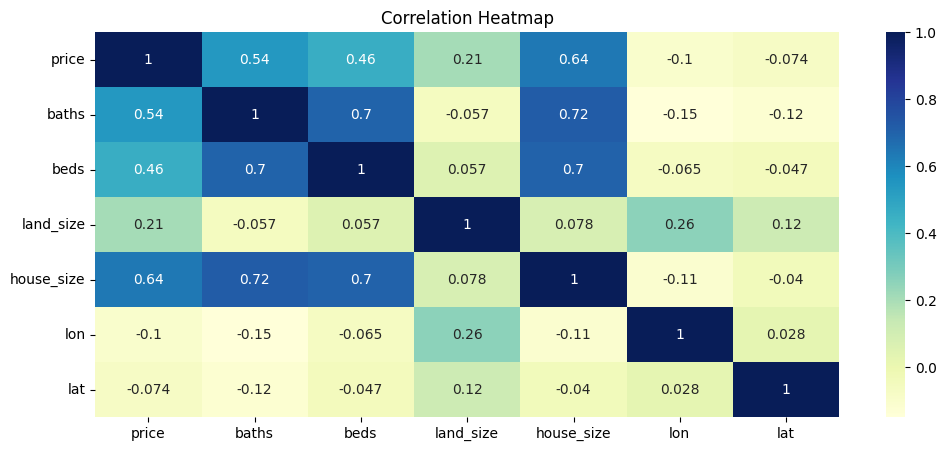

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['price','baths', 'beds', 'land_size', 'house_size', 'lon', 'lat']].corr()

plt.figure(figsize=(12,5))
plt.title('Correlation Heatmap')
sns.heatmap(corr, annot=True, cmap='YlGnBu')

#### published date analysis

In [137]:
# analyze published date

temp_df['published_year'] = df['published_date'].dt.year
temp_df['published_month'] = df['published_date'].dt.month
temp_df['published_day'] = df['published_date'].dt.day
temp_df['published_hour'] = df['published_date'].dt.hour
temp_df['published_day_of_week'] = df['published_date'].dt.dayofweek

# print unique values
print('published_year: ', temp_df['published_year'].unique())
print('published_month: ', temp_df['published_month'].unique())
print('published_day: ', temp_df['published_day'].unique())
print('published_hour: ', temp_df['published_hour'].unique())
print('published_day_of_week: ', temp_df['published_day_of_week'].unique())

published_year:  [2021]
published_month:  [11 10  9]
published_day:  [ 6 24 17  8 13 15 12 25 14 29  4 10  3  9  2  5 11 19 16 27 30 23 26 28
 21 20  7 22  1 31 18]
published_hour:  [14  7 17 16 12 15 11 21  8 10 13  9 20 23 19  0  6  4  1 22 18  3  5  2]
published_day_of_week:  [5 6 2 0 4 3 1]


In [138]:
# drop published_year since all values are 2021
temp_df = temp_df.drop(columns=['published_year'], errors='ignore')

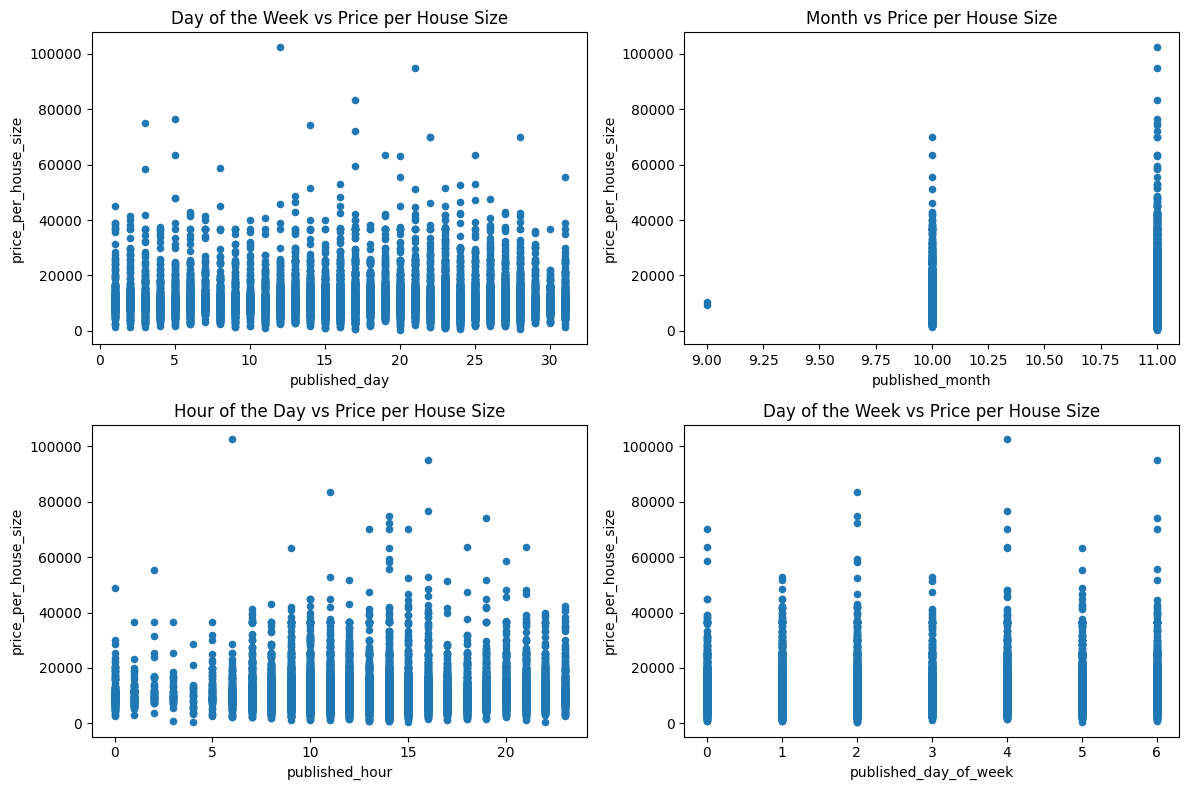

In [139]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Scatter plot 1 - published_day vs price_per_house_size
temp_df.plot(kind='scatter', x='published_day', y='price_per_house_size', ax=axes[0, 0])
axes[0, 0].set_title('Day of the Week vs Price per House Size')

# Scatter plot 2 - published_month vs price_per_house_size
temp_df.plot(kind='scatter', x='published_month', y='price_per_house_size', ax=axes[0, 1])
axes[0, 1].set_title('Month vs Price per House Size')

# Scatter plot 3 - published_hour vs price_per_house_size
temp_df.plot(kind='scatter', x='published_hour', y='price_per_house_size', ax=axes[1, 0])
axes[1, 0].set_title('Hour of the Day vs Price per House Size')

# Scatter plot 4 - published_day_of_week vs price_per_house_size
temp_df.plot(kind='scatter', x='published_day_of_week', y='price_per_house_size', ax=axes[1, 1])
axes[1, 1].set_title('Day of the Week vs Price per House Size')

plt.tight_layout()
plt.show()


#### coordinate analysis

In [140]:
# get unique coordinates
unique_coordinates = df[['lon', 'lat']].drop_duplicates()
print(f'coordinates {len(unique_coordinates)}/{len(df)}')

coordinates 141/12311


Coordinates provided in the dataset are approximate coordinates. There are only 141 unique records out of 12311 records.

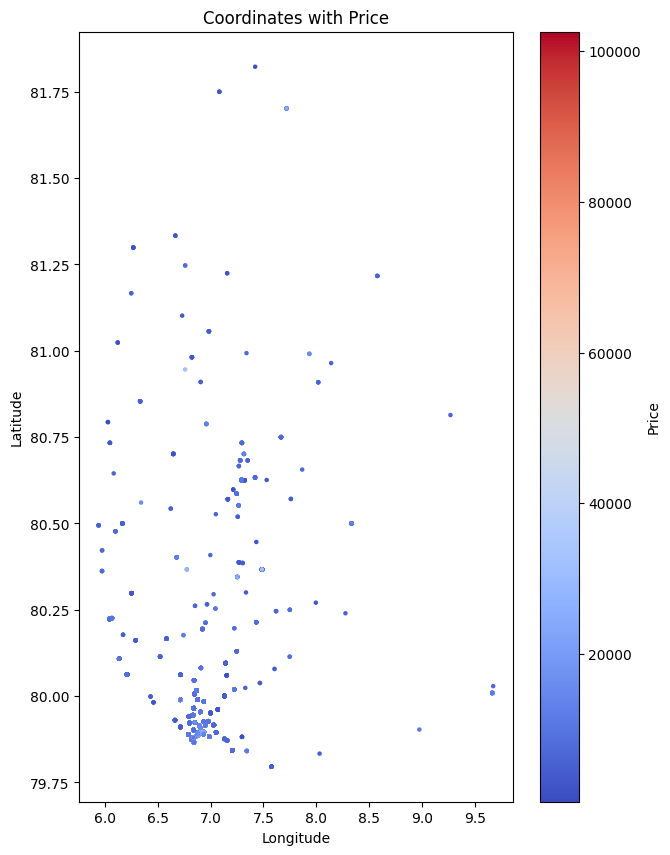

In [141]:
# Scatter plot with color representing price
plt.figure(figsize=(7, 10))
plt.scatter(df['lat'], df['lon'], c=temp_df['price_per_house_size'], cmap='coolwarm', s=5)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinates with Price')
plt.show()


#### district and city analysis

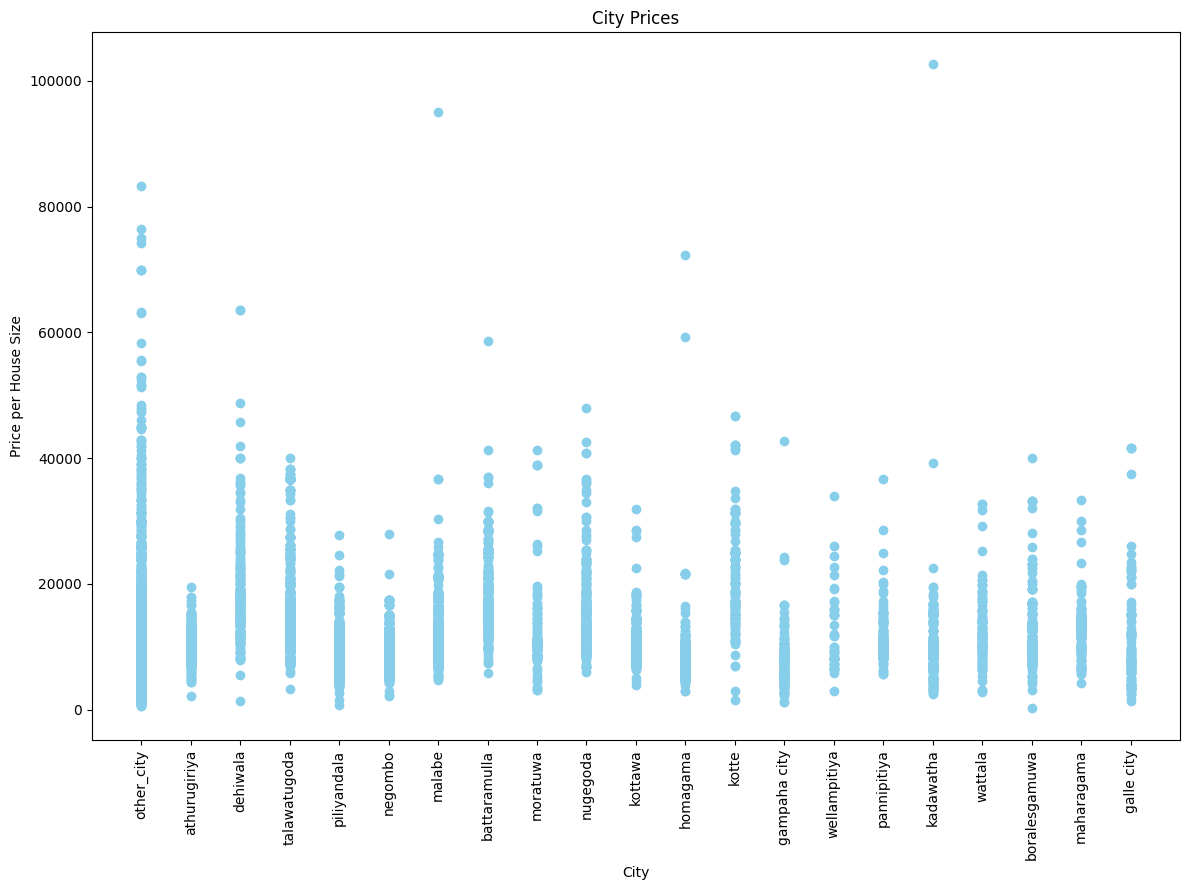

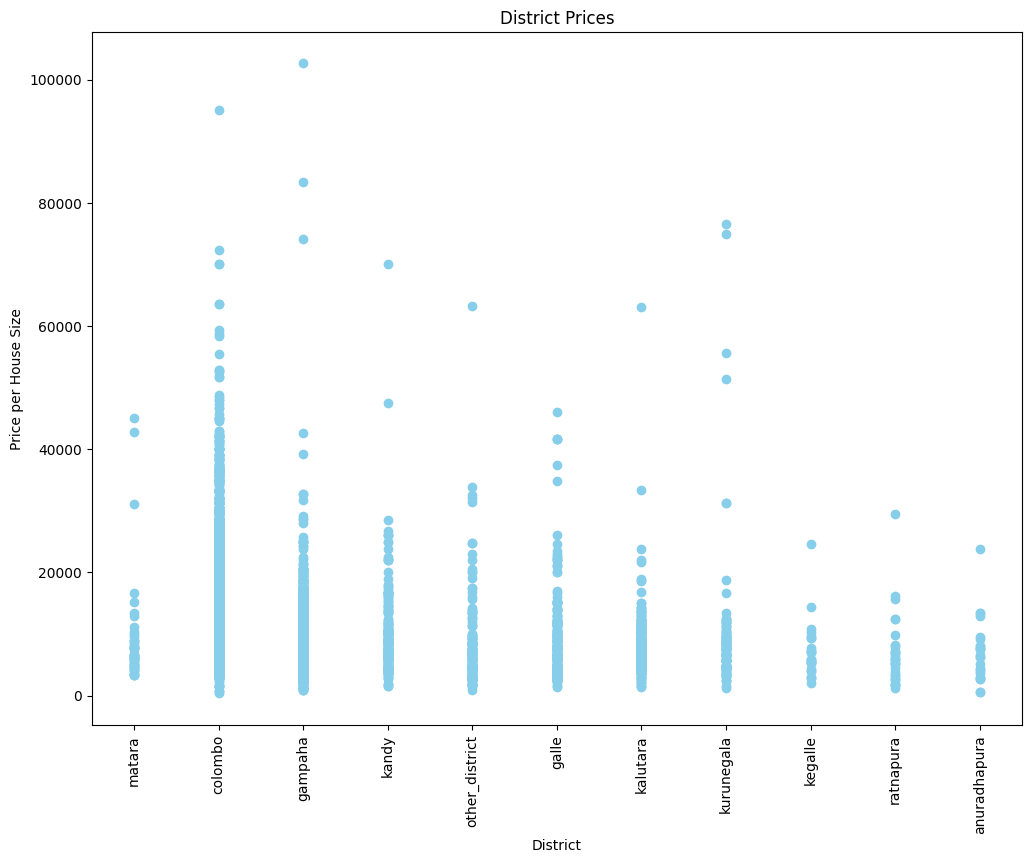

In [142]:
import matplotlib.pyplot as plt

# cities
plt.figure(figsize=(12, 9))
plt.scatter(df['city'], temp_df['price_per_house_size'], color='skyblue')
plt.title('City Prices')
plt.xlabel('City')
plt.ylabel('Price per House Size')
plt.xticks(rotation=90)
plt.tight_layout()

# districts
plt.figure(figsize=(12, 9))
plt.scatter(df['district'], temp_df['price_per_house_size'], color='skyblue')
plt.title('District Prices')
plt.xlabel('District')
plt.ylabel('Price per House Size')
plt.xticks(rotation=90)



# Display the chart
plt.show()


#### beds and baths analysis

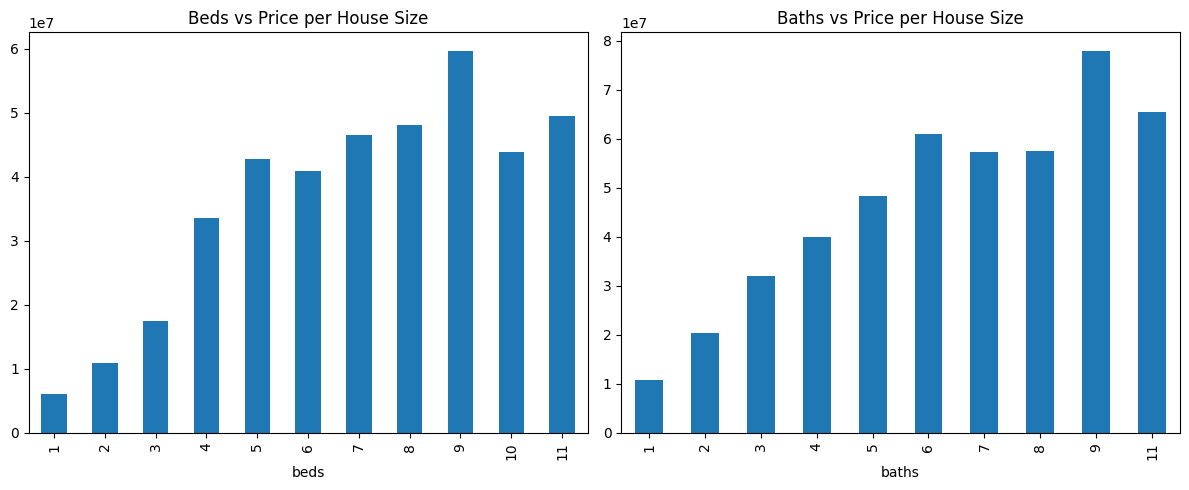

In [143]:
#beds and baths anlysis with price separately with two different plots in 2 columns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot 1 - beds vs price_per_house_size
df.groupby('beds')['price'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Beds vs Price per House Size')

# Scatter plot 2 - baths vs price_per_house_size
df.groupby('baths')['price'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Baths vs Price per House Size')

plt.tight_layout()
plt.show()


#### house size and land size analysis

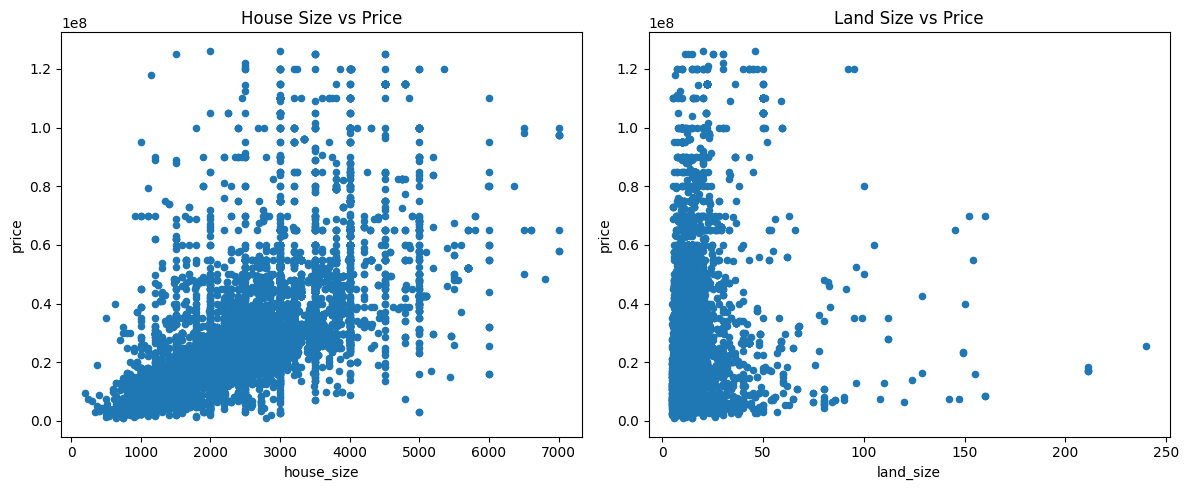

In [144]:
# house size and land size analysis with price separately with two different plots in 2 columns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot 1 - house_size vs price_per_house_size
df.plot(kind='scatter', x='house_size', y='price', ax=axes[0])
axes[0].set_title('House Size vs Price')

# Scatter plot 2 - land_size vs price_per_house_size
df.plot(kind='scatter', x='land_size', y='price', ax=axes[1])
axes[1].set_title('Land Size vs Price')

plt.tight_layout()
plt.show()

### feature generation

In [145]:
df['sqft_per_bed'] = df['house_size'] / df['beds']
df['house_land_ratio'] = df['house_size'] / df['land_size'] / 272.25 #floor count
df['garden_size'] = (df['land_size'] * 272.25) - (df['house_size'] / np.ceil(df['house_land_ratio']))
df['baths_per_bed'] = df['baths'] / df['beds']

### Normalization

In [655]:
df.describe()

,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,garden_size,baths_per_bed
count,1.231100e+04,12311.000000,12311.000000,12311.000000,12311.00000,12311,12311.000000,12311.000000,12311.000000,12311.000000,12311.000000,12311.000000
mean,2.967204e+07,2.903257,12.523925,3.953294,2501.37258,2021-11-09 21:43:16.351230464,79.971505,6.913106,630.911028,0.898437,1544.541092,0.731586
min,9.250000e+05,1.000000,5.000000,1.000000,200.00000,2021-09-19 21:01:00,79.795675,5.941424,100.000000,0.016325,0.000000,0.272727
25%,1.650000e+07,2.000000,8.000000,3.000000,1610.00000,2021-10-30 21:04:30,79.913892,6.801844,500.000000,0.561767,578.000000,0.600000
50%,2.550000e+07,3.000000,10.000000,4.000000,2500.00000,2021-11-12 08:23:00,79.930510,6.877014,625.000000,0.857668,972.500000,0.750000
75%,3.500000e+07,4.000000,12.850000,4.000000,3100.00000,2021-11-20 10:20:30,79.989929,6.935757,750.000000,1.204293,1403.125000,1.000000
max,1.262250e+08,11.000000,240.000000,11.000000,7000.00000,2021-11-29 01:35:00,81.822554,9.673491,1000.000000,4.000334,59340.000000,1.222222
std,2.046660e+07,1.179220,10.785057,1.193951,982.32554,NaN,0.162370,0.238914,169.443557,0.426415,2756.098251,0.215104


In [656]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

df[['house_size', 'land_size', 'sqft_per_bed', 'house_land_ratio', 'garden_size', 'baths_per_bed']] = std_scaler.fit_transform(df[['house_size', 'land_size', 'sqft_per_bed', 'house_land_ratio', 'garden_size', 'baths_per_bed']])

df[['beds', 'baths']] = minmax_scaler.fit_transform(df[['beds', 'baths']])

# TODO : lat lon scaling

df.describe()

,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,garden_size,baths_per_bed
count,1.231100e+04,12311.000000,1.231100e+04,12311.000000,1.231100e+04,12311,12311.000000,12311.000000,1.231100e+04,1.231100e+04,1.231100e+04,1.231100e+04
mean,2.967204e+07,0.190326,1.010032e-16,0.295329,-1.431359e-16,2021-11-09 21:43:16.351230464,79.971505,6.913106,5.309880e-17,-1.061976e-16,5.771609e-19,-1.038890e-16
min,9.250000e+05,0.000000,-6.976533e-01,0.000000,-2.342875e+00,2021-09-19 21:01:00,79.795675,5.941424,-3.133389e+00,-2.068752e+00,-5.604313e-01,-2.133277e+00
25%,1.650000e+07,0.100000,-4.194794e-01,0.200000,-9.074474e-01,2021-10-30 21:04:30,79.913892,6.801844,-7.726251e-01,-7.895659e-01,-3.507061e-01,-6.117554e-01
50%,2.550000e+07,0.200000,-2.340301e-01,0.300000,-1.397333e-03,2021-11-12 08:23:00,79.930510,6.877014,-3.488635e-02,-9.561311e-02,-2.075631e-01,8.560880e-02
75%,3.500000e+07,0.300000,3.023520e-02,0.300000,6.094230e-01,2021-11-20 10:20:30,79.989929,6.935757,7.028524e-01,7.173026e-01,-5.131233e-02,1.247882e+00
max,1.262250e+08,1.000000,2.109264e+01,1.000000,4.579755e+00,2021-11-29 01:35:00,81.822554,9.673491,2.178330e+00,7.274650e+00,2.097088e+01,2.281015e+00
std,2.046660e+07,0.117922,1.000041e+00,0.119395,1.000041e+00,NaN,0.162370,0.238914,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00


### Encoding categorical attributes

In [657]:
#one hot encoding
df = pd.get_dummies(df, columns=['city'], prefix='', prefix_sep='')
df = pd.get_dummies(df, columns=['district'], prefix='', prefix_sep='')


### Training model

In [658]:
df.columns

Index(['price', 'baths', 'land_size', 'beds', 'house_size', 'published_date',
       'lon', 'lat', 'sqft_per_bed', 'house_land_ratio', 'garden_size',
       'baths_per_bed', 'athurugiriya', 'battaramulla', 'boralesgamuwa',
       'dehiwala', 'galle city', 'gampaha city', 'homagama', 'kadawatha',
       'kottawa', 'kotte', 'maharagama', 'malabe', 'moratuwa', 'negombo',
       'nugegoda', 'other_city', 'pannipitiya', 'piliyandala', 'talawatugoda',
       'wattala', 'wellampitiya', 'anuradhapura', 'colombo', 'galle',
       'gampaha', 'kalutara', 'kandy', 'kegalle', 'kurunegala', 'matara',
       'other_district', 'ratnapura'],
      dtype='object')

In [660]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if 'published_date' in df.columns:
    df = df.drop(columns=['published_date'])

# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Support Vector Regression': SVR(kernel='linear'),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the statistics
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2) Score: {r2}")
    print()


Model: Linear Regression
Mean Absolute Error: 7332251.13393236
Mean Squared Error: 139039247503057.95
R-squared (R2) Score: 0.6559345591138348

Model: Ridge Regression
Mean Absolute Error: 7337981.310501463
Mean Squared Error: 139114132754049.56
R-squared (R2) Score: 0.6557492486539395



C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.774e+17, tolerance: 4.161e+14
  model = cd_fast.enet_coordinate_descent(


Model: Lasso Regression
Mean Absolute Error: 7332248.496355873
Mean Squared Error: 139039233214461.84
R-squared (R2) Score: 0.6559345944722836

Model: Elastic Net
Mean Absolute Error: 9482968.418768011
Mean Squared Error: 217176074382914.4
R-squared (R2) Score: 0.4625777748053431

Model: Support Vector Regression
Mean Absolute Error: 13375495.192235911
Mean Squared Error: 418961845726042.2
R-squared (R2) Score: -0.03675972614165546

Model: Decision Tree Regressor
Mean Absolute Error: 3877764.127910273
Mean Squared Error: 110321990989306.53
R-squared (R2) Score: 0.7269980588154401

Model: Random Forest Regressor
Mean Absolute Error: 3383491.3584256675
Mean Squared Error: 62769250572578.29
R-squared (R2) Score: 0.8446717005435941

Model: Gradient Boosting Regressor
Mean Absolute Error: 5575476.7628315715
Mean Squared Error: 88513705870209.1
R-squared (R2) Score: 0.7809646716188389

